In [1]:
import queryer
import copy
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
egdata = queryer.get_earthquake_eager()
print([k for k in egdata[0]])# for one earthquake here are the dictionarnum_py,y keys

['eventlat', 'eventdepth', 'eventlon', 'eventid', 'data', 'magnitude']


In [ ]:
all_lat = np.asfarray([station['stationlat'] for station in egdata[0]['data']],float)
all_lon = np.asfarray([station['stationlon'] for station in egdata[0]['data']],float)

def remove_outside_bounds(lats, lons, lat_bound, lon_bound):
    """Args:
    lats: a float array of station latitudes
    lons: a float array of station longitudes
    lat_bound: a boolean function for filtering lats
    lon_bound: a boolean function for filtering lons
       
    Return:
    modified_lats: lats with any out of bounds removed
    modified_lons: lons with any out of bounds removed
    """
    inside_bounds = [(lat,lon) for lat,lon in zip(lats, lons)
                     if lat_bound(lat) and lon_bound(lon)]
    return [lat for lat,lon in inside_bounds], [lon for lat,lon in inside_bounds]

modified_lat, modified_lon =  remove_outside_bounds(
    all_lat, all_lon,
    lambda lat: lat>53.0,
    lambda lon: lon>5.8)

plt.plot(modified_lon,modified_lat,'b*')
plt.show()
def filter_coords(candidatelist, keeper_coords):
    stations_matching_akeeper = [i for i in candidatelist
                    if any(coords_match(i, keeper_coords))]
    return stations_matching_akeeper
def coords_match(record, latlons):
    def checker(record, latlon): 
        latmatches = float(record['stationlat'])==latlon[0]
        lonmatches = float(record['stationlon'])==latlon[1]
        return latmatches and lonmatches
    return [checker(record, i) for i in latlons]
def filter_stations(egdata, stations_coords_to_keep):
    new_data = copy.deepcopy(egdata)
    for k in range(len(egdata)):
        new_data[k]['data'] = filter_coords(new_data[k]['data'], stations_coords_to_keep)
    return new_data
filtered_data = filter_stations(egdata, list(zip(modified_lat, modified_lon)))
       
for station in egdata[0]['data']:
    plt.plot(float(station['stationlon']),float(station['stationlat']),'y*')
for k in range(len(egdata)-2):
    plt.plot( egdata[k]['eventlon'], egdata[k]['eventlat'],'sk')
for station in filtered_data[0]['data']:
    plt.plot(float(station['stationlon']),float(station['stationlat']),'b*')

In [ ]:
def slicecalcer(dataarray, slicelen, metric):
    n,t=np.shape(dataarray)
    slice_steps = np.arange(0,t+1,slicelen)
    slices = [dataarray[:,i[0]:i[1]] for i in zip(slice_steps, slice_steps[1::])]
    
    metrics = np.asarray([metric(arr, axis=1) for arr in slices]).T
    return metrics
def discretiser(plen_x,plen_y, x,y):
    #plen_x : pixel length(degree) in x dim
    #plen_y : pixel length(degree) in y dim
    n = int(x/plen_x)
    m = int(y/plen_y)
    return (n,m)
def grid_translation(topleft, stationlat, stationlon):

    lon_ref = topleft[0]
    lat_ref = topleft[1]

    dx = (stationlon-lon_ref)
    dy = (lat_ref-stationlat)
    return (dx,dy)

manytimeseries = egdata[0]['data']
def extract_raw_timeseries(quake_records):
    maxlen = max([len(quake['ts']) for quake in quake_records ])
    return np.vstack([quake['ts'] for quake in quake_records
                     if len(quake['ts']) ==maxlen])

justdata =  extract_raw_timeseries(egdata[0]['data'])
print(np.shape(justdata))
dataarray = np.zeros((len(manytimeseries),manytimeseries[0]['ts'].size))
i=0
for stationdata in manytimeseries:
    dataarray[i,0:stationdata['ts'].size] = np.array(stationdata['ts'])
    i+=1
    
slicelen =400
metric = np.max
metrics = slicecalcer(dataarray, slicelen, metric)

stationdeets = np.asarray([[i.get('stationlat'),i.get('stationlon')]
                                for i in manytimeseries])
lat,lon = np.asarray([stationdeets[i,:] for i in range(stationdeets.shape[0])],float).T
print(lat.shape[0])

#turn into grid

topleft = np.asarray([6.4,53.50]) #-> initialize the top left part
plen_x = 0.01 #-> angle that is covered by one pixel in x dir
plen_y = 0.01 #-> angle that is covered by one pixel in y dir
size_x = 0.8  #-> total covered angle in xdir (longitudes)
size_y = 0.45 #-> total covere angle in ydir (lattitudes)
#initialize the grid : 2D zeros matrix
slice_grid = np.zeros((int(size_y/plen_y),int(size_x/plen_x),metrics.shape[1]))

x,y = np.asarray([grid_translation(topleft,lat[i],lon[i]) for i in range(lat.shape[0])]).T
n,m = np.asarray([discretiser(plen_x,plen_y,x[i],y[i]) for i in range(x.shape[0])]).T

x_eq,y_eq = grid_translation(topleft,float(egdata[0]['eventlat']),float(egdata[0]['eventlon']))
n_eq,m_eq = discretiser(plen_x,plen_y,x_eq,y_eq)

# print(x)
# print(m)
print(slice_grid.shape)

for time_slice in range(metrics.shape[1]):
    for station in range(metrics.shape[0]):
        #print(m[station],n[station])
        val = np.absolute(metrics[station,time_slice])
        if val<4000:
            slice_grid[m[station],n[station],time_slice]=val
            #print(metrics[station,0])

print(type(slice_grid))
#slice_grid[m_eq,n_eq,0]=500
#print(slice_grid)
max_row= np.max(np.max(slice_grid,axis=0))
max_column =np.max(np.max(slice_grid,axis=1))
print(max_row,max_column)

from matplotlib.patches import Circle

for i in range(slice_grid.shape[2]):
    ax=plt.imshow(slice_grid[:,:,i])
    circ = plt.Circle((n_eq,m_eq),1,fc='r')
    plt.gca().add_patch(circ)
    plt.show()

for i in [0]:
    ax=plt.imshow(slice_grid[:,:,i])
    circ = plt.Circle((n_eq,m_eq),0.01,fc='r')
    plt.gca().add_patch(circ)
    plt.show()




In [ ]:
from scipy import interpolate

grid_x = np.arange(slice_grid.shape[1])
#grid_y = np.flip(np.arange(slice_grid.shape[0]),axis=0)
grid_y = np.arange(slice_grid.shape[0])

print(grid_x)
print(grid_y)

X, Y = np.meshgrid(grid_x, grid_y)
Z = slice_grid[:,:,0]
print(Y)
plt.subplot(2, 1, 1)
plt.pcolormesh(X,Y,Z)
plt.gca().invert_yaxis()

print(Z.shape)

F = interpolate.interp2d(X,Y,Z,kind='linear')

x_new = np.arange(0,slice_grid.shape[1],0.5)
#y_new = np.flip(np.arange(0,slice_grid.shape[0],1),axis=0)
y_new = np.arange(0,slice_grid.shape[0],0.5)

print(y_new)
z_new = F(x_new,y_new)
#print(Z)
#print(z_new)
plt.subplot(2, 1, 2)
Xn, Yn = np.meshgrid(x_new, y_new)
plt.pcolormesh(Xn, Yn, z_new,cmap='hot')
plt.gca().invert_yaxis()

print(type(z_new))
print(z_new.shape)
#plt.imshow(z_new)


In [2]:
from tile_creater import earthquake_to_training_and_label, gps_distance, latlon_to_idxer, get_pixel_lens

In [3]:
topleft = (53.5, 6.4)
sizex = 0.8
sizey = 0.4
numx= 180
numy = 90
slicelen=200
frames_per_eg = 10
plen_x, plen_y = get_pixel_lens(numx, numy, sizex, sizey)
topright = (topleft[0]+sizex, topleft[1])
bottomleft = (topleft[0], topleft[1]+sizey)
print(gps_distance(topleft, topright))
print(gps_distance(topleft, bottomleft))

coords = (egdata[0]['eventlat'], egdata[0]['eventlon'])
quake_x, quake_y = latlon_to_idxer(topleft,plen_x, plen_y)(*coords)
print(quake_x, quake_y)

label, tiles = earthquake_to_training_and_label(topleft,sizex,sizey,
                                                numx, numy,slicelen,
                                                frames_per_eg, egdata[0])
print(label)

88.98386658367902
26.464781019759027
123 62
(53.223, 6.949, 3.0, 0.502994544, 'knmi2018etrn')


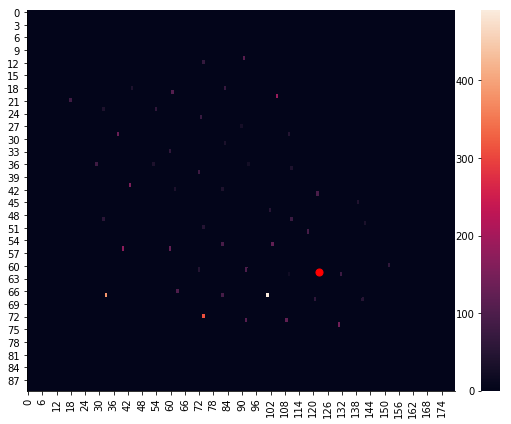

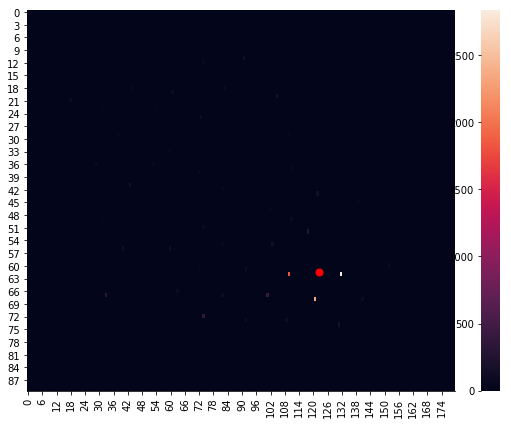

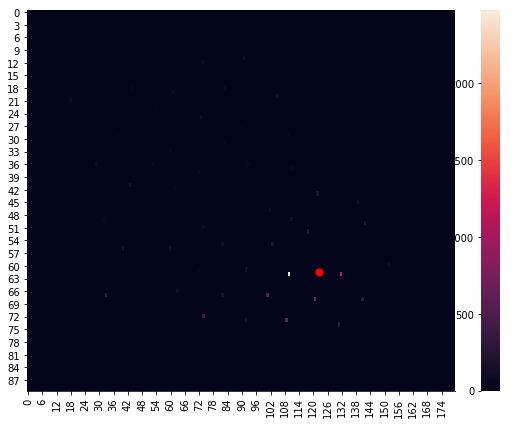

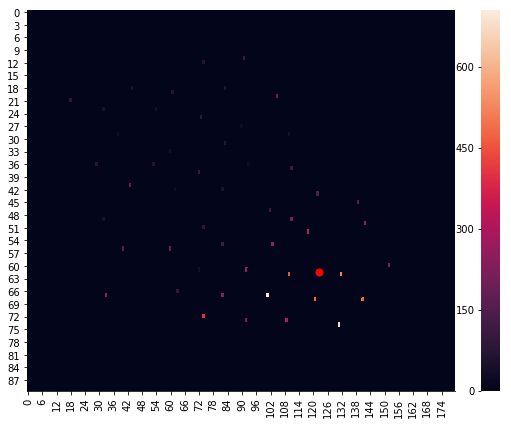

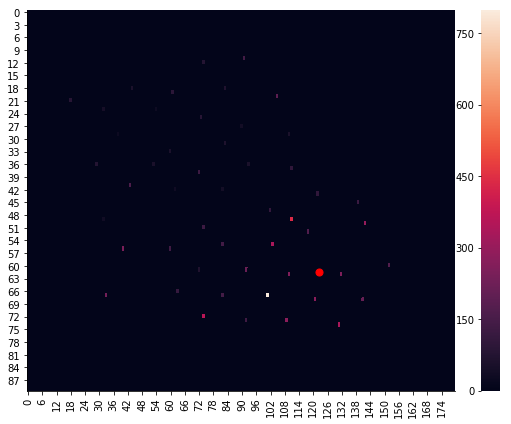

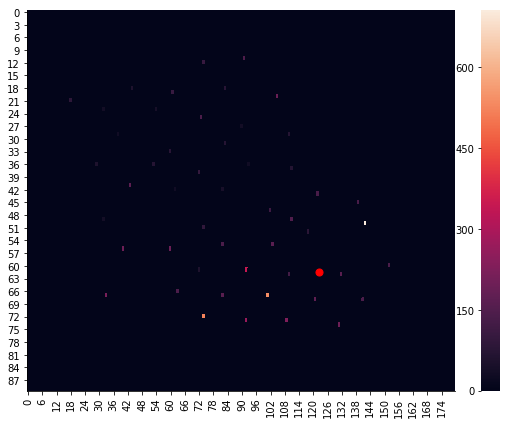

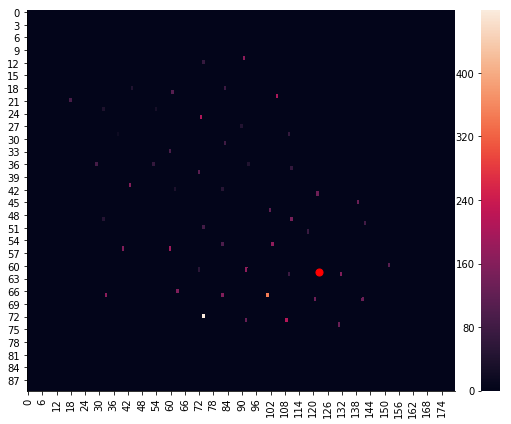

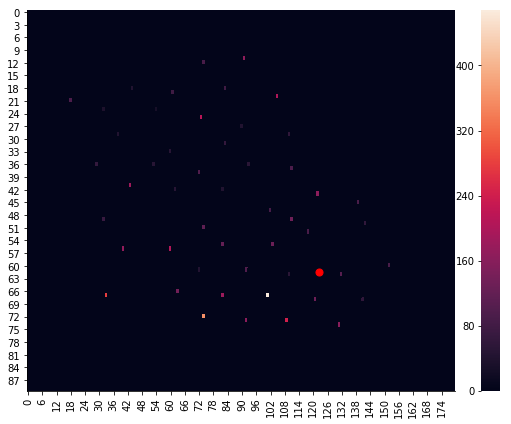

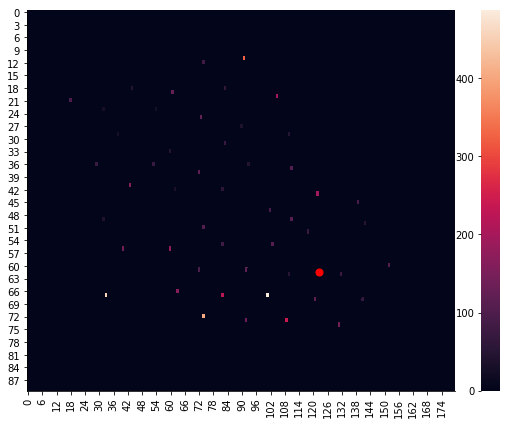

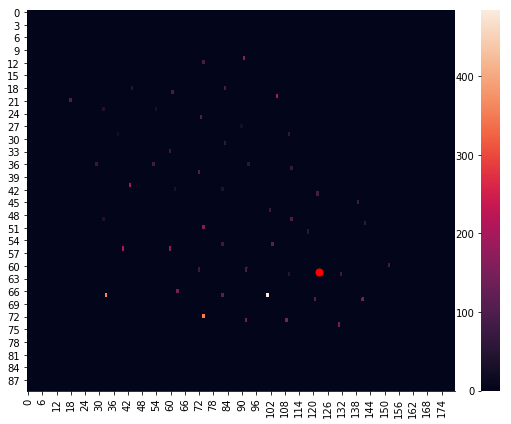

In [4]:
import seaborn as sns
nonzeros = list(zip(*np.nonzero(tiles[0])))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
def plot_slice(tslice):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.heatmap(tslice, ax=ax)
    #ax.set_aspect('equal')
    ax.scatter(quake_x,quake_y, marker='o', color = 'r', s=50)
    sns.despine()
    fig.tight_layout()
    #fig.savefig('inspecttile', dpi=600)
for tslice in tiles[0:10]:
    plot_slice(tslice)


In [ ]:
fig, ax = plt.subplots(1)
ax.plot(egdata[0]['data'][100]['ts'][0:20000])
sns.despine()

In [ ]:
def zeromean(a, axis=1):
    avg = np.mean(a, axis =1)
    return (a.transpose() - avg).transpose()

In [ ]:
import functools, helpers
a = np.array([[4,1],[1,2], [3,4]])
zeropeaker = helpers.pipe(zeromean, np.max)

In [ ]:
zeromean(a, axis = 1)

In [ ]:
np.max(zeromean(a, axis=1), axis=1)

In [ ]:
np.array([1,2,3])-2